# Causal Impact of Incentives on Birth Rate

After reading and discussing two *Financial Times* articles with a friend, I became interested in the effectiveness of incentives aimed at increasing birthrates.  

### **Key Takeaways from the Articles**  
- Developed countries are experiencing a **sharp decline in birthrates**.  
- The majority of countries now have a **fertility rate below the population replacement rate** ([source](https://en.wikipedia.org/wiki/List_of_countries_by_total_fertility_rate#Country_ranking_by_international_organizations)).  
- This decline is expected to **lower living standards** for younger generations as they reach retirement age.  
- Without a significant economic shift, there may not be enough workers to sustain economic growth.  

### **Our Discussion**  
My friend and I explored potential solutions, particularly the role of **artificial intelligence (AI)** in mitigating workforce shortages. We shared the assumption that **reversing the declining birthrate trend is extremely difficult, if not impossible**.  

Some key points from our discussion:  
- Once a country reaches a certain level of **development, having children may become a lower priority**.  
- **Japan serves as a strong case study** since it resists immigration and faces a rapidly aging population.  
- Even in countries that welcome immigration, if global birthrate declines persist, there may **eventually be too few people to fill workforce gaps—even through immigration**.  
- The trend appears to be **universal, cutting across cultures and persisting despite government incentives**.  

### **The Central Question**  
Given that the articles argue governmental aid and incentives have had **limited success**, I wanted to investigate from a causal inference perspective:  
***Are these incentives actually making a difference?***

---

**Financial Times Articles:**

1. [Falling birth rates raise prospect of sharp decline in living standards
](https://www.ft.com/content/19cea1e0-4b8f-4623-bf6b-fe8af2acd3e5) 
2. [The baby gap: why governments can’t pay their way to higher birth rates](https://www.ft.com/content/2f4e8e43-ab36-4703-b168-0ab56a0a32bc)

In [13]:
import pandas as pd
import numpy as np
from graphviz import Digraph
import graphviz as gr
from IPython.display import Image
from dowhy import CausalModel
import dowhy.plotter
import matplotlib
import cvxpy as cp
from matplotlib import pyplot as plt
from matplotlib import font_manager
from matplotlib.font_manager import FontProperties
from cycler import cycler
from linearmodels import PanelOLS

### Causal Graph

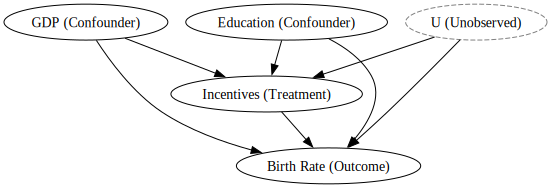

In [2]:
causal_graph = Digraph(name="Causal Graph", format="png", engine="dot")

causal_graph.node("Incentives", "Incentives (Treatment)")
causal_graph.node("BirthRate", "Birth Rate (Outcome)")
causal_graph.node("GDP", "GDP (Confounder)")
causal_graph.node("Education", "Education (Confounder)")
causal_graph.node("U", "U (Unobserved)", color="gray", style="dashed")

causal_graph.edges([
    ("Incentives", "BirthRate"),
    ("GDP", "Incentives"),
    ("GDP", "BirthRate"),
    ("Education", "Incentives"),
    ("Education", "BirthRate"),
    ("U", "Incentives"),
    ("U", "BirthRate")
])

causal_graph

### Load Data

In [3]:
pd_gdp = pd.read_csv("data/GDP/gdp.csv")

In [4]:
pd_gdp[9:14]
pd_gdp.drop(index=[9,10,11,12,13], inplace=True)
pd_gdp.drop(columns=["Series Code"], inplace=True)

In [5]:
df_fertility = pd.read_csv("data/fertilityRate/fertility.csv")

In [6]:
df_fertility.drop(index=[9,10,11,12,13], inplace=True)
df_fertility.drop(columns=["Series Code"], inplace=True)

In [7]:
df_edu = pd.read_csv('data/Education/edu.csv')

df_edu['Series Name'] = df_edu['Series Name'].str.strip()

target_series = [
    "Labor force, female (% of total labor force)",
    "Educational attainment, at least completed post-secondary, population 25+, female (%) (cumulative)",
    "Educational attainment, at least completed post-secondary, population 25+, total (%) (cumulative)",
    "Educational attainment, at least Bachelor's or equivalent, population 25+, female (%) (cumulative)",
    "Educational attainment, at least Bachelor's or equivalent, population 25+, total (%) (cumulative)"
]

# dictionary of DataFrames
dfs = {name: df_edu[df_edu['Series Name'] == name].copy() for name in target_series}

In [8]:
# Access individual DataFrames 
labor_female_df = dfs[target_series[0]]
labor_female_df.drop(columns=["Series Code"], inplace=True)

In [9]:
post_secondary_female_df = dfs[target_series[1]]
post_secondary_female_df.drop(columns=["Series Code"], inplace=True)

In [10]:
post_secondary_total_df = dfs[target_series[2]]
post_secondary_total_df.drop(columns=["Series Code"], inplace=True)

In [11]:
post_bachelor_female_df = dfs[target_series[3]]
post_bachelor_female_df.drop(columns=["Series Code"], inplace=True)

In [12]:
post_bachelor_total_df = dfs[target_series[4]]
post_bachelor_total_df.drop(columns=["Series Code"], inplace=True)

### Long Data

In [13]:
fertility_long = (
    df_fertility
    .melt(
        id_vars=['Country Name', 'Country Code', 'Series Name'],
        var_name='Year',
        value_name='Fertility_Rate'
    )
    # Extract year from strings like "1990 [YR1990]"
    .assign(Year=lambda x: x['Year'].str.extract(r'(\d{4})').astype(int))
    .query("`Country Name` in ['Japan', 'Korea, Rep.', 'Sweden']")
)

In [14]:
gdp_long = (
    pd_gdp.melt(
        id_vars=['Country Name', 'Country Code', 'Series Name'],
        var_name='Year',
        value_name='GDP'
    ).assign(Year=lambda x: x['Year'].str.extract(r'(\d{4})').astype(int))
)

In [15]:
labor_female_long = (
    labor_female_df.melt(
        id_vars=['Country Name', 'Country Code', 'Series Name'],
        var_name='Year',
        value_name='Labor_Force_Female'
    ).assign(Year=lambda x: x['Year'].str.extract(r'(\d{4})').astype(int))
)

In [16]:
post_secondary_female_long = (
    post_secondary_female_df.melt(
        id_vars=['Country Name', 'Country Code', 'Series Name'],
        var_name='Year',
        value_name='Post_Secondary_Female'
    ).assign(Year=lambda x: x['Year'].str.extract(r'(\d{4})').astype(int))
)

In [17]:
post_secondary_total_long = (
    post_secondary_total_df.melt(
        id_vars=['Country Name', 'Country Code', 'Series Name'],
        var_name='Year',
        value_name='Post_Secondary_Total'
    ).assign(Year=lambda x: x['Year'].str.extract(r'(\d{4})').astype(int))
)

In [18]:
post_bachelor_female_long = (
    post_bachelor_female_df.melt(
        id_vars=['Country Name', 'Country Code', 'Series Name'],
        var_name='Year',
        value_name='Post_Bachelor_Female'
    ).assign(Year=lambda x: x['Year'].str.extract(r'(\d{4})').astype(int))
)

In [19]:
post_bachelor_total_long = (
    post_bachelor_total_df.melt(
        id_vars=['Country Name', 'Country Code', 'Series Name'],
        var_name='Year',
        value_name='Post_Bachelor_Total'
    ).assign(Year=lambda x: x['Year'].str.extract(r'(\d{4})').astype(int))
)

In [20]:
# remove Series to fix dupicate columns error
fertility_clean = fertility_long[['Country Name', 'Year', 'Fertility_Rate']]
gdp_clean = gdp_long[['Country Name', 'Year', 'GDP']]
post_secondary_clean = post_secondary_total_long[['Country Name', 'Year', 'Post_Secondary_Total']]
post_bachelor_clean = post_bachelor_total_long[['Country Name', 'Year', 'Post_Bachelor_Total']]
labor_female_clean = labor_female_long[['Country Name', 'Year', 'Labor_Force_Female']]

In [21]:
merged = (
    fertility_clean
    .merge(gdp_clean, on=['Country Name', 'Year'], how='inner')
    .merge(post_secondary_clean, on=['Country Name', 'Year'])
    .merge(post_bachelor_clean, on=['Country Name', 'Year'])
    .merge(labor_female_clean, on=['Country Name', 'Year'])
    .sort_values(['Country Name', 'Year'])
)
merged

,Country Name,Year,Fertility_Rate,GDP,Post_Secondary_Total,Post_Bachelor_Total,Labor_Force_Female
2,Japan,1990,1.54,3.185905e+12,..,..,40.3360443427619
5,Japan,1991,1.53,3.648066e+12,..,..,40.52626586869
8,Japan,1992,1.5,3.980703e+12,..,..,40.4376587387491
11,Japan,1993,1.46,4.536940e+12,..,..,40.2343732460394
14,Japan,1994,1.5,4.998798e+12,..,..,40.2418012479353
...,...,...,...,...,...,...,...
87,Sweden,2019,1.71,5.321693e+11,40,25.0799999237061,47.4352661367012
90,Sweden,2020,1.67,5.451476e+11,49.8847312927246,32.5396308898926,47.1515158165803
93,Sweden,2021,1.67,6.371869e+11,49.3100547790527,32.6667137145996,47.2323542656069
96,Sweden,2022,1.52,5.798957e+11,50.8245239257812,33.6940689086914,47.167795771586


## Japan: Angel Plan (1994)

In [22]:
# Filter data to Japan (treated) and Sweden (control)
did_df = merged.query(
    "`Country Name` in ['Japan', 'Sweden']"  
).copy()

did_df['Labor_Force_Female'] = pd.to_numeric(did_df['Labor_Force_Female'], errors='coerce')
did_df['Fertility_Rate'] = pd.to_numeric(did_df['Fertility_Rate'], errors='coerce')

In [23]:
# treatment variables
did_df['post'] = (did_df['Year'] >= 1994)  # Post-Angel Plan period
did_df['treated_country'] = (did_df['Country Name'] == 'Japan')  # Japan = treated
did_df['did'] = did_df['treated_country'] * did_df['post']  # Interaction term

In [24]:
did_df

,Country Name,Year,Fertility_Rate,GDP,Post_Secondary_Total,Post_Bachelor_Total,Labor_Force_Female,post,treated_country,did
2,Japan,1990,1.54,3.185905e+12,..,..,40.336044,False,True,False
5,Japan,1991,1.53,3.648066e+12,..,..,40.526266,False,True,False
8,Japan,1992,1.50,3.980703e+12,..,..,40.437659,False,True,False
11,Japan,1993,1.46,4.536940e+12,..,..,40.234373,False,True,False
14,Japan,1994,1.50,4.998798e+12,..,..,40.241801,True,True,True
...,...,...,...,...,...,...,...,...,...,...
87,Sweden,2019,1.71,5.321693e+11,40,25.0799999237061,47.435266,True,False,False
90,Sweden,2020,1.67,5.451476e+11,49.8847312927246,32.5396308898926,47.151516,True,False,False
93,Sweden,2021,1.67,6.371869e+11,49.3100547790527,32.6667137145996,47.232354,True,False,False
96,Sweden,2022,1.52,5.798957e+11,50.8245239257812,33.6940689086914,47.167796,True,False,False


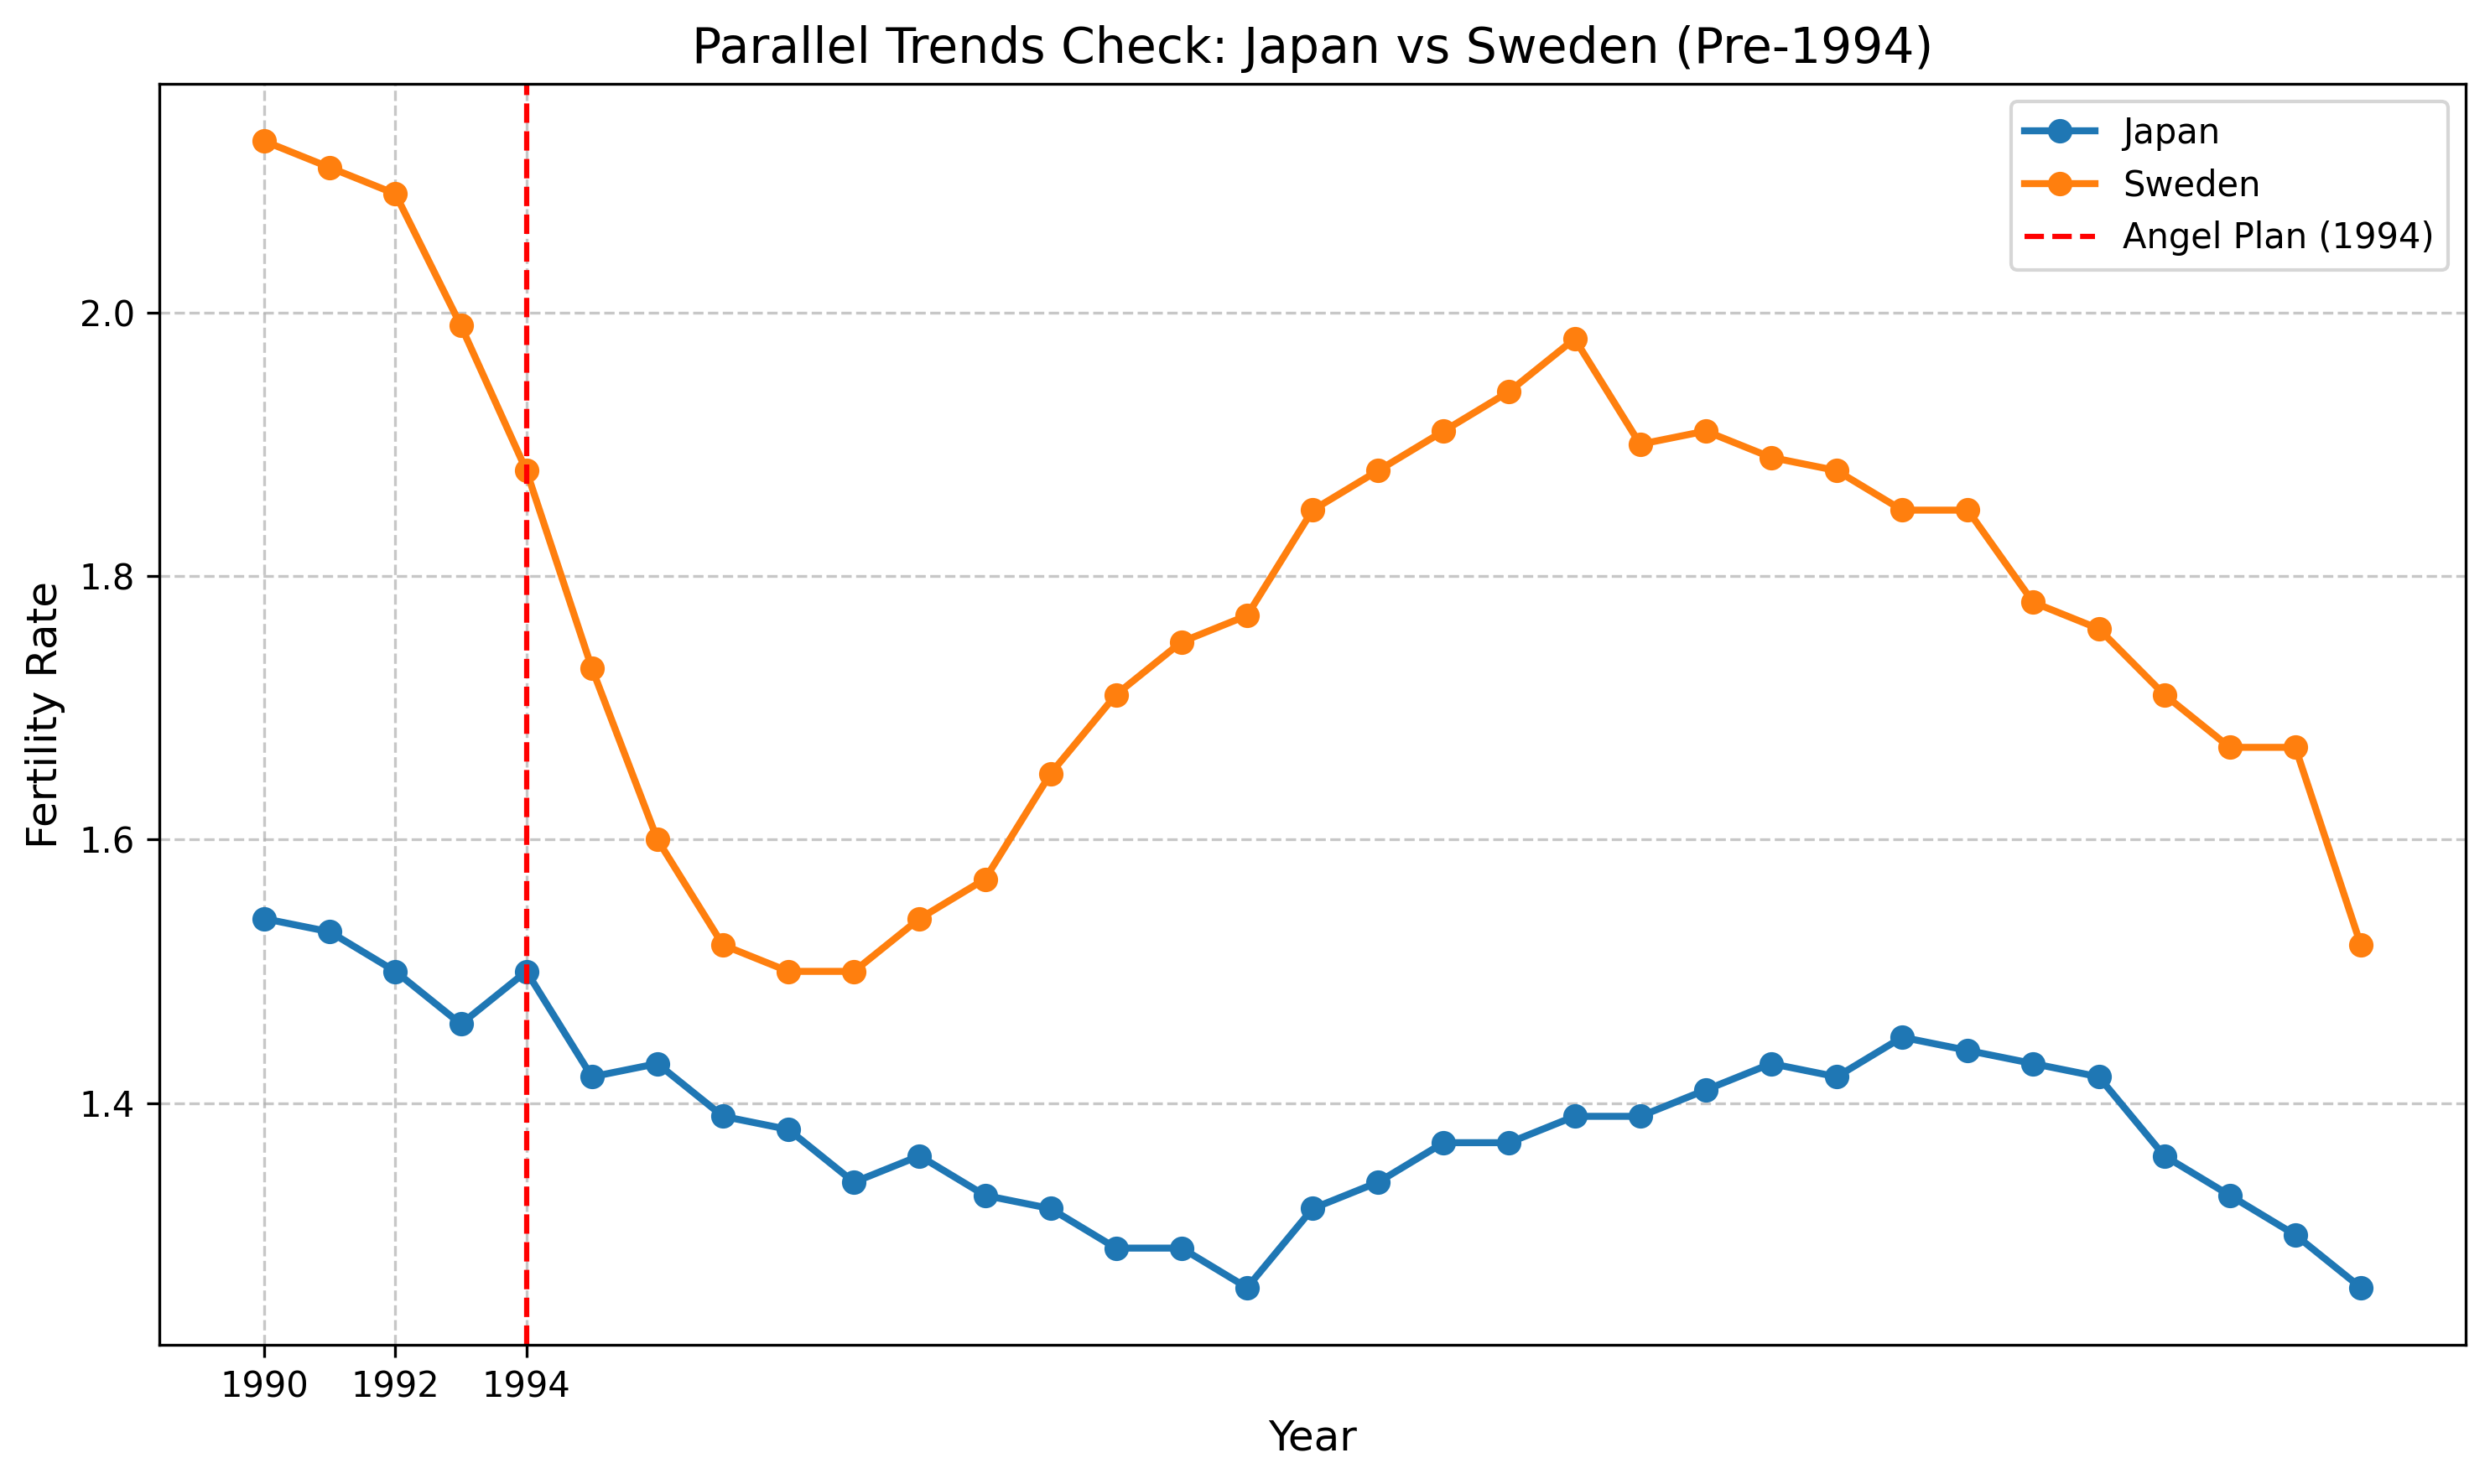

In [25]:
# Plot trends pre-1994, Parallel Trends check
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

# Plot each country's trend
for country in ['Japan', 'Sweden']:
    country_data = did_df[did_df['Country Name'] == country]
    ax.plot(
        country_data['Year'],
        country_data['Fertility_Rate'],
        label=country,
        linewidth=2,
        marker='o'
    )

# Add policy line and labels
ax.axvline(1994, color='red', linestyle='--', label='Angel Plan (1994)')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Fertility Rate', fontsize=12)
ax.set_title('Parallel Trends Check: Japan vs Sweden (Pre-1994)', fontsize=14)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7)

ax.set_xticks(range(did_df['Year'].min(), 1995, 2))
plt.tight_layout()
plt.show()

Definetly not the best parallel, even with a shift of 1, but for this exercise, it will do.

In [37]:
# panel structure
# did_df = did_df.set_index(['Country Name', 'Year'])

# Model formula (with controls)
# model = PanelOLS.from_formula(
#     """Fertility_Rate ~ 
#        GDP + EntityEffects + TimeEffects""",
#     data=did_df
# )
# results = model.fit(cov_type='clustered', cluster_entity=True)
# print(results.summary)

## Korea: Baby Bonus (2001 and 2024)

In [23]:
merged['korea_treatment_2001'] = (
    (merged['Country Name'] == 'Korea, Rep.') & 
    (merged['Year'] > 2001)
)
merged['korea_treatment_2024'] = (
    (merged['Country Name'] == 'Korea, Rep.') & 
    (merged['Year'] > 2024)
)

### Synthetic Control for Korea's 2001 Policy

In [24]:
korea_data = merged[merged['Country Name'] == 'Korea, Rep.'].copy()

In [25]:
korea_data.dtypes

Country Name             object
Year                      int64
Fertility_Rate           object
GDP                     float64
Post_Secondary_Total     object
Post_Bachelor_Total      object
Labor_Force_Female       object
japan_treatment            bool
korea_treatment_2001       bool
korea_treatment_2024       bool
dtype: object

In [26]:
korea_data['Labor_Force_Female'] = pd.to_numeric(korea_data['Labor_Force_Female'], errors='coerce')
korea_data['Fertility_Rate'] = pd.to_numeric(korea_data['Fertility_Rate'], errors='coerce')

In [27]:
pre_treatment = korea_data[korea_data['Year'] <= 2001]
post_treatment = korea_data[korea_data['Year'] > 2001]

In [28]:
X_pre = np.array(pre_treatment[['GDP', 'Labor_Force_Female']].values, dtype=float)
Y_pre = pre_treatment['Fertility_Rate'].values  # Outcome

In [29]:
w = cp.Variable(X_pre.shape[1])  # Weights for predictors
intercept = cp.Variable()

In [30]:
# Objective: Minimize error in pre-treatment period
objective = cp.Minimize(cp.norm(Y_pre - (X_pre @ w + intercept), 2))
constraints = []  # No constraints on weights

In [31]:
# Solve optimization problem
problem = cp.Problem(objective, constraints)
problem.solve()

/Users/elizabeth/causal_env/lib/python3.10/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [32]:
X_post = np.array(post_treatment[['GDP', 'Labor_Force_Female']].values, dtype=float)
synthetic_Y_post = X_post @ w.value + intercept.value

In [33]:
synthetic_Y_post

array([1.37582578, 1.41971878, 1.34002943, 1.29450355, 1.25108354,
       1.24518615, 1.24665652, 1.29396723, 1.25917912, 1.24304045,
       1.22207715, 1.18549597, 1.12371609, 1.0799965 , 1.05379496,
       1.00686032, 0.96027165, 0.92627518, 0.92411596, 0.86758341,
       0.84946731, 0.78137462])

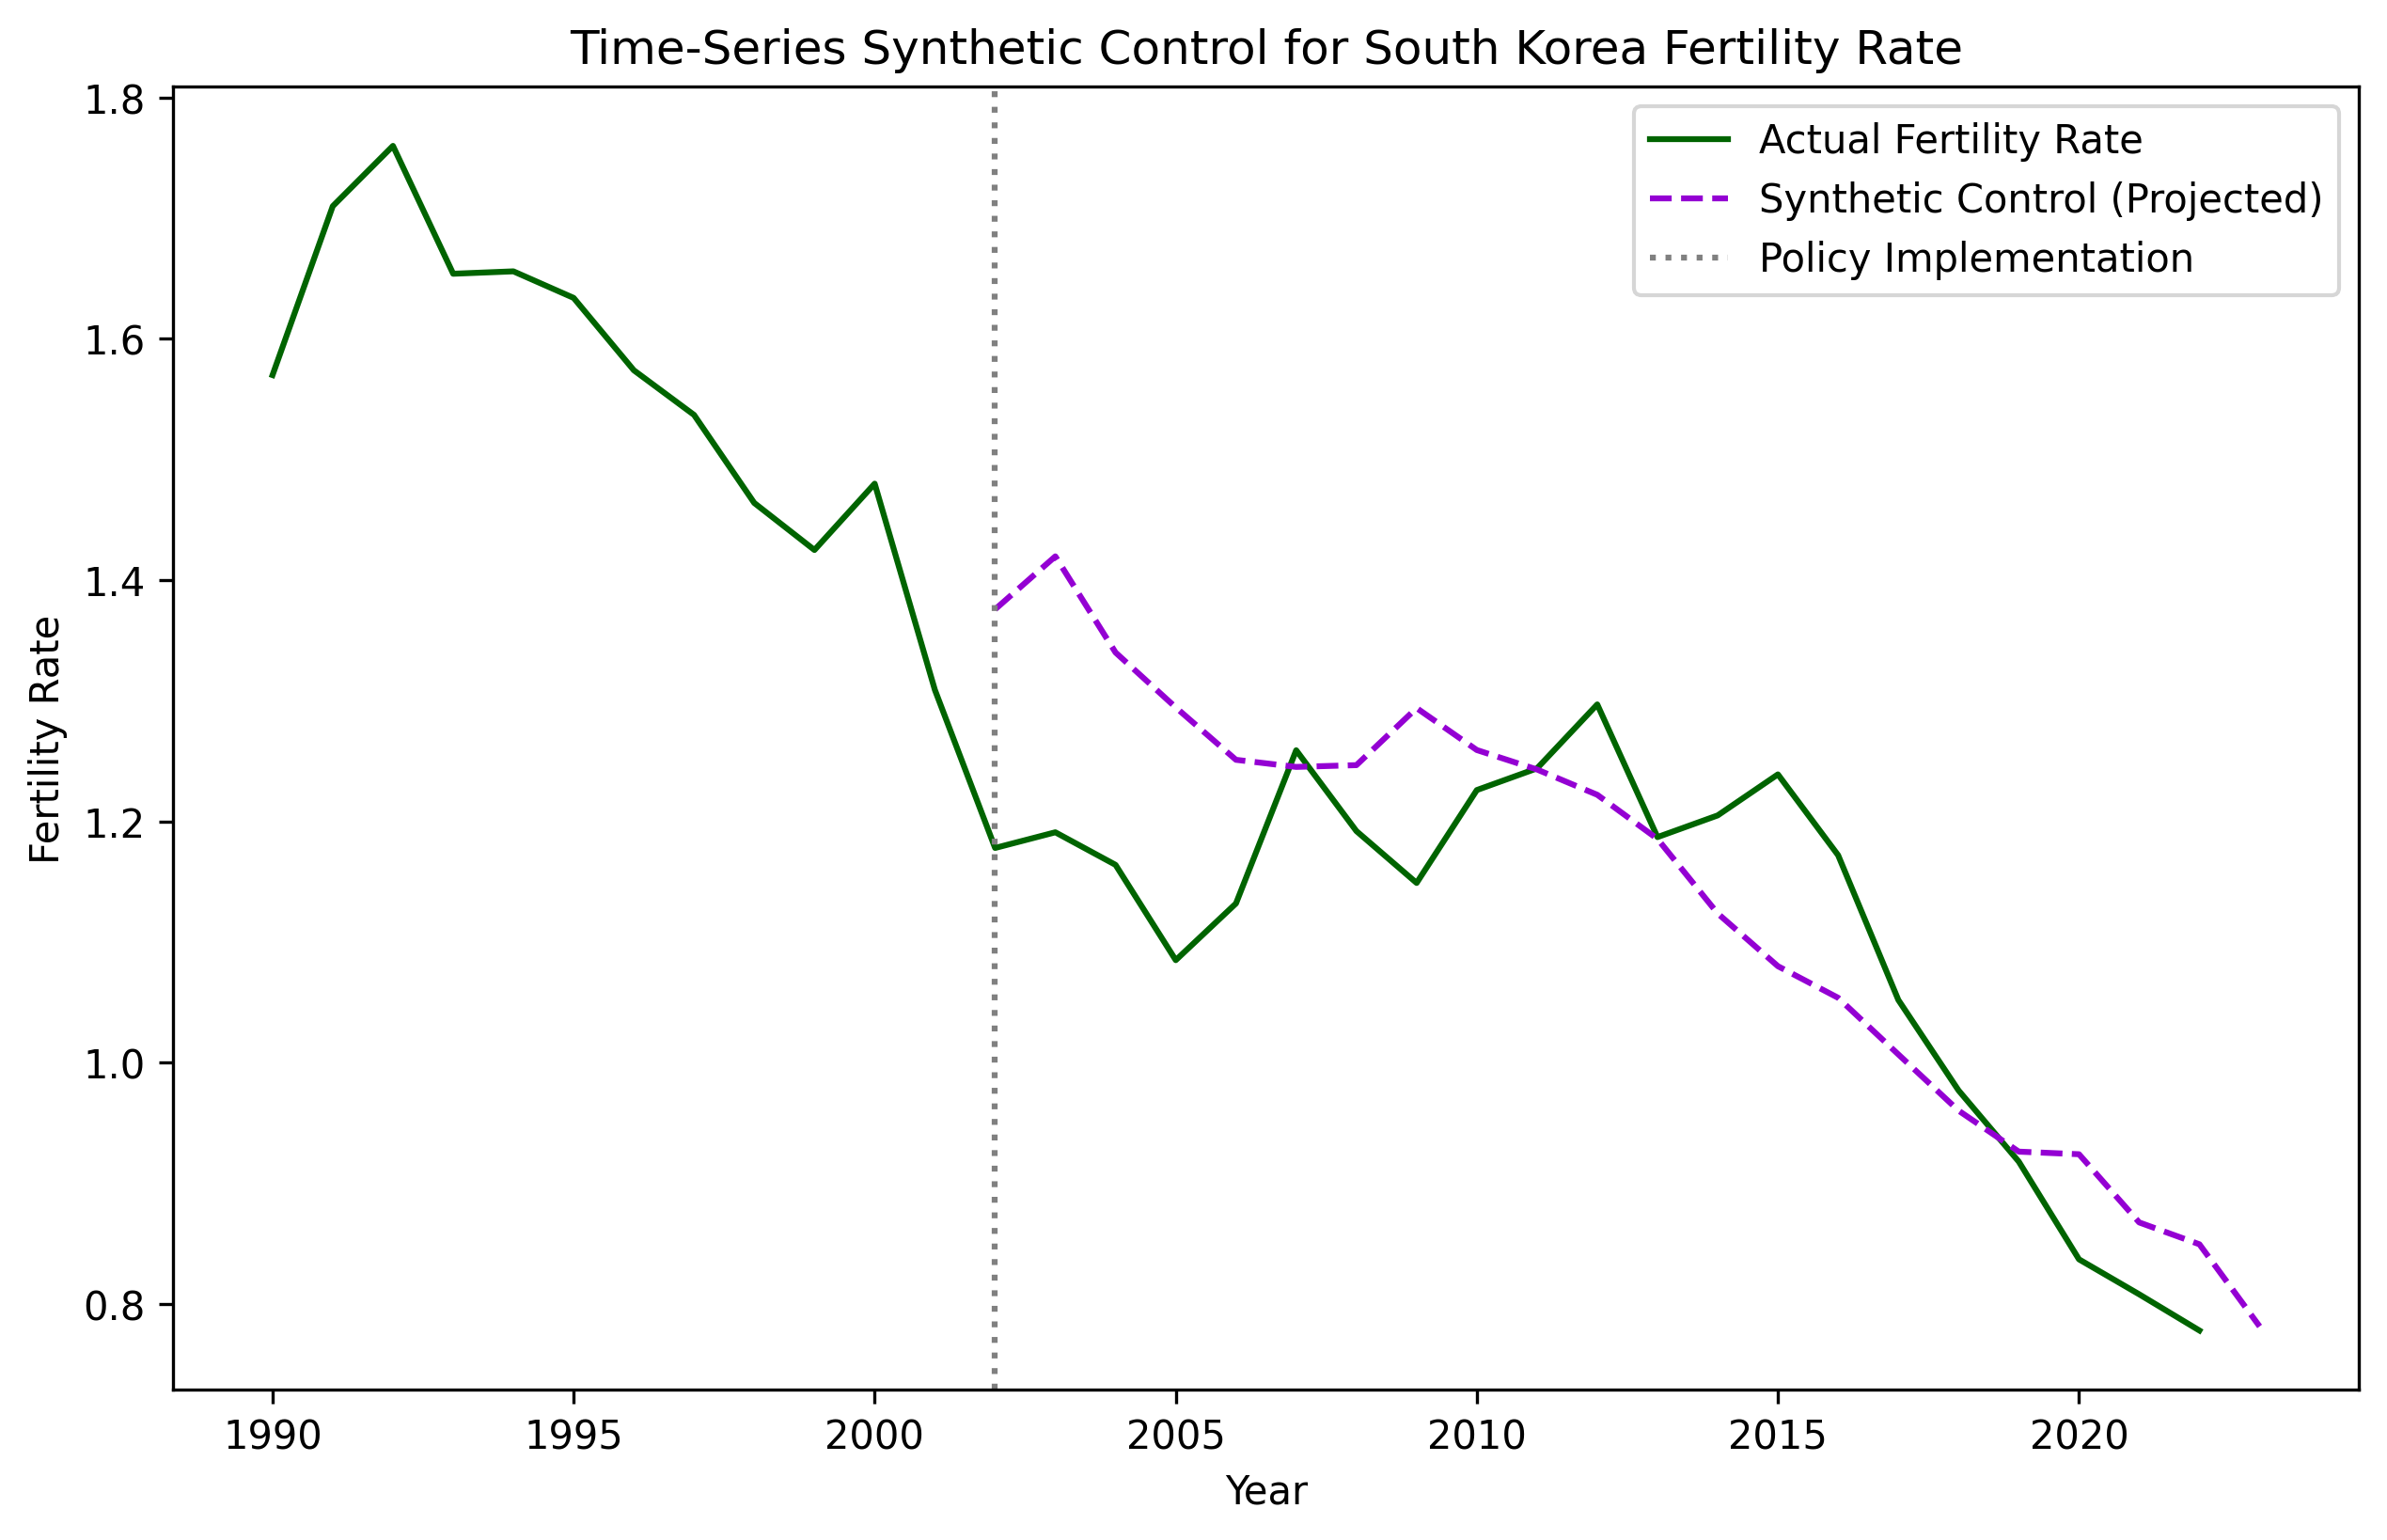

In [35]:
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(korea_data['Year'], korea_data['Fertility_Rate'], label="Actual Fertility Rate", color="darkgreen")
plt.plot(post_treatment['Year'], synthetic_Y_post, label="Synthetic Control (Projected)", color="darkviolet", linestyle="--")
plt.axvline(x=2002, color='gray', linestyle=':', label='Policy Implementation')
plt.xlabel("Year")
plt.ylabel("Fertility Rate")
plt.title("Time-Series Synthetic Control for South Korea Fertility Rate")
plt.legend()
plt.show()

### Difference-in-Differences (DiD)

### Propensity Score Matching (PSM)

### Doubly Robust (DR) Estimation

### Visualization

In [23]:
personal_path = '../Fonts_GT_Super/Desktop/GT-Super'
font_path = personal_path + '/GT-Super-Display-Regular-Trial.otf'
font = FontProperties(fname=font_path)
bold_font = FontProperties(fname=personal_path + '/GT-Super-Display-Bold-Trial.otf')

In [ ]:
# https://data.worldbank.org/indicator/SP.DYN.TFRT.IN?end=2022&start=1987

In [15]:
df_fertility = df_fertility.drop(columns=["Series Name"])

In [16]:
df_long = df_fertility.melt(id_vars=["Country Name", "Country Code"], 
                            var_name="Year", 
                            value_name="Birth Rate")

In [17]:
df_long["Year"] = df_long["Year"].str.extract(r"(\d{4})").astype(int)

In [18]:
df_long = df_long[(df_long["Year"] >= 1990) & (df_long["Year"] <= 2022)]

In [19]:
# Get unique countries
countries = df_long["Country Name"].unique()
num_countries = len(countries)

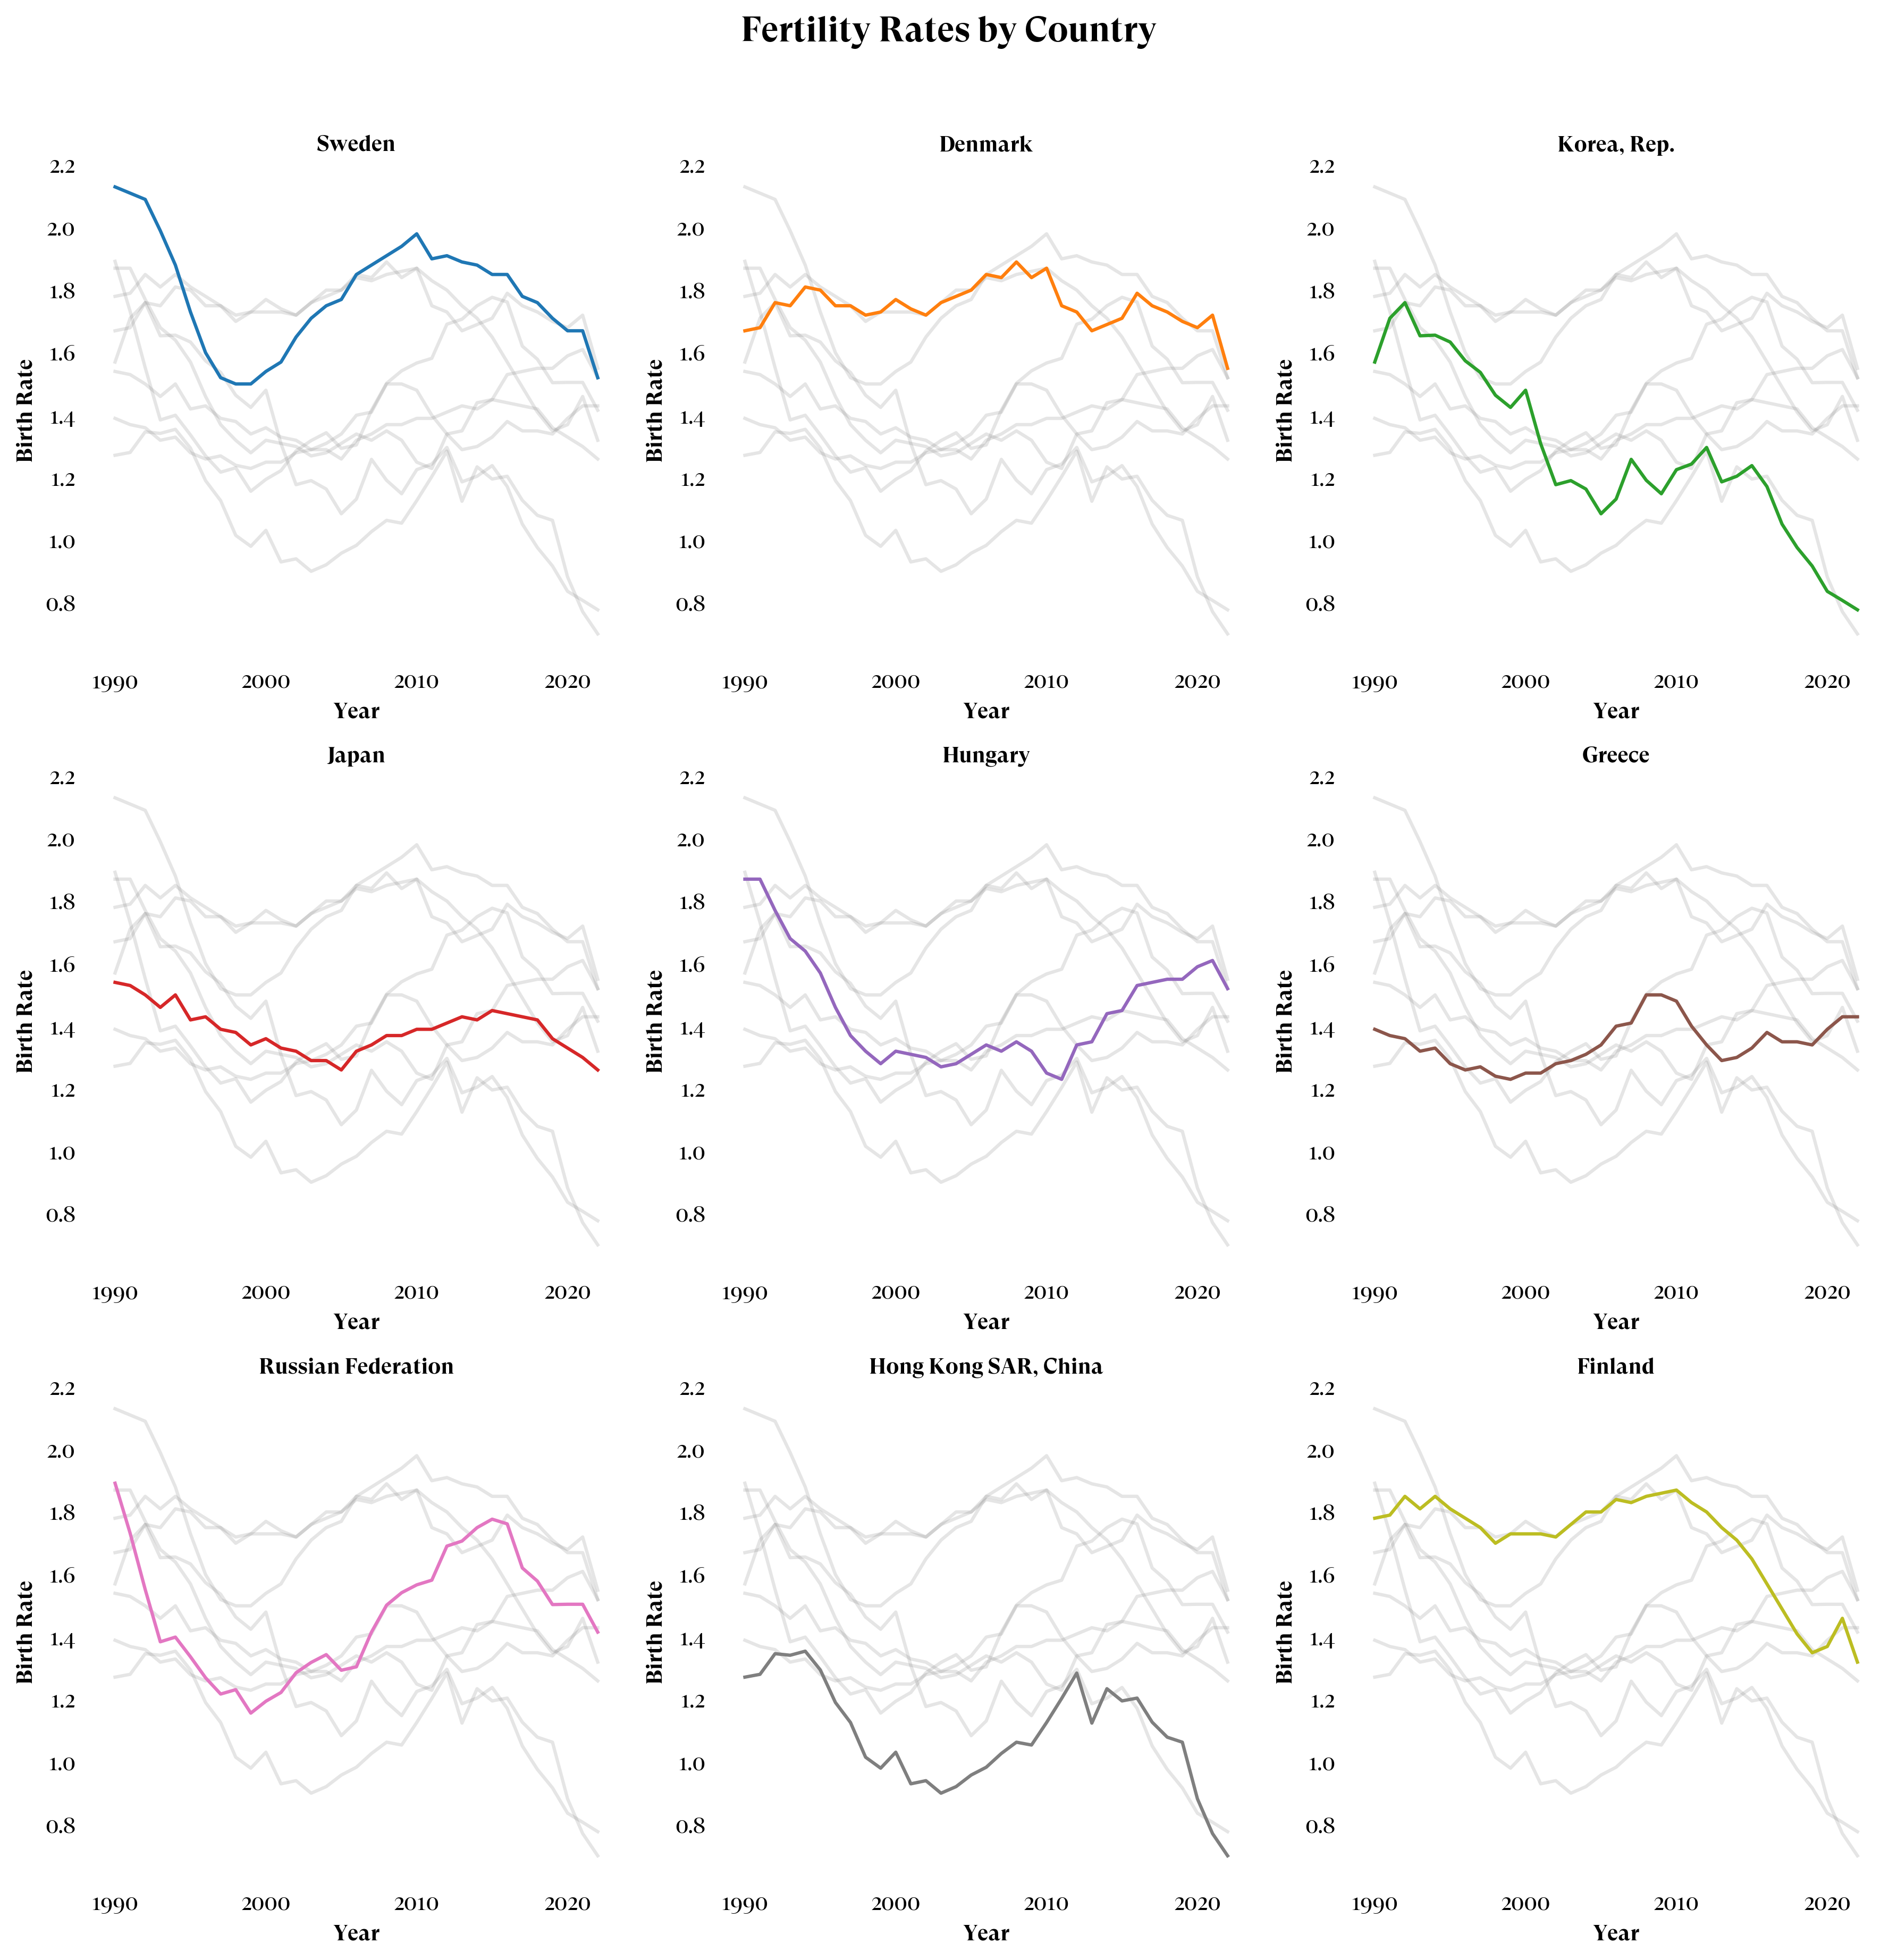

In [26]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12), dpi=300)
axes = axes.flatten() 
colors = plt.colormaps.get_cmap('tab10')

for i, (country, ax) in enumerate(zip(countries, axes)):
    country_data = df_long[df_long["Country Name"] == country]
    
    # Plot all other countries in gray
    for other_country in countries:
        if other_country != country:
            other_data = df_long[df_long["Country Name"] == other_country]
            ax.plot(other_data["Year"], other_data["Birth Rate"], color="gray", alpha=0.2)

    # Plot the main country in color
    ax.plot(country_data["Year"], country_data["Birth Rate"], color=colors(i), linestyle="-")

    ax.set_title(country, fontsize=12, font=bold_font)
    ax.set_xlabel("Year", font=bold_font)
    ax.set_ylabel("Birth Rate", font=bold_font)
    
    # Remove unnecessary spines
    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    
    ax.tick_params(axis="x", which="both", bottom=False, top=False)  # Hide x-axis ticks
    ax.tick_params(axis="y", which="both", left=False, right=False)  # Hide y-axis ticks

    for label in ax.get_xticklabels():
        label.set_fontproperties(font)

    for label in ax.get_yticklabels():
        label.set_fontproperties(font)


fig.suptitle("Fertility Rates by Country", fontsize=16, font=bold_font, y=1.02)

plt.tight_layout()
plt.savefig("fertility_rates.png", dpi=300, bbox_inches="tight")
plt.show()